In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import Tuple
import json

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind")

def cscale(rgba: Tuple[float, float, float, float], m: float) -> Tuple[float, float, float, float]:
    return (rgba[0] * m, rgba[1] * m, rgba[2] * m, rgba[3])


def cmap_extreme(map: colors.Colormap, min=0, max=1) -> colors.Colormap:
    class Wrap(colors.Colormap):
        def __init__(self, cmap: colors.Colormap):
            self.cmap = cmap
        def __getattr__(self, name):
            if name == "cmap": return self.cmap
            return getattr(self.cmap, name)
        def __eq__(self, other):
            self.cmap.__eq__(other)
        def __copy__(self):
            Wrap(self.cmap.__copy__())
        def __call__(self, X, alpha=None, bytes=False):
            if isinstance(X, np.ndarray):
                X = X - (X <= min) + (X >= max)
            if isinstance(X, float) or isinstance(X, int):
                if X <= min:
                    return self.cmap(X - 1.0, alpha, bytes)
                if X >= max:
                    return self.cmap(X + 1.0, alpha, bytes)
            return self.cmap(X, alpha, bytes)

    return Wrap(map.with_extremes(
        under=cscale(map(-1.0), 0.5), over=cscale(map(2.0), 0.5)))

def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    # out = out.reshape(((huge_pages + 31) // 32, 32))
    return pd.DataFrame(out)


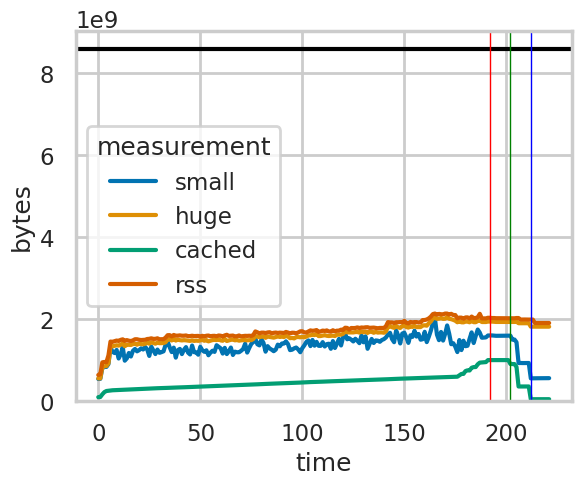

In [3]:
# Buddy, Free-Page-Reporting, 8G, 8C
root = Path("compiling/240325-113045-base-auto")
max_mem = 8*1024**3
data = pd.read_csv(root / "out_0.csv")
data["small"] = max_mem - data["small"] * 2**12
data["huge"] = max_mem - data["huge"] * 2**(12+9)
data["alloc"] = "LLFree"
data["time"] = data.index
data = data.melt(
    id_vars=["alloc", "time"],
    var_name="measurement",
    value_name="bytes",
    value_vars=["small", "huge", "cached", "rss"])
times = json.load((root / "times_0.json").open())

p = sns.lineplot(data=data, x="time", y="bytes", hue="measurement")
p.set_ylim(0, max_mem * 1.05)
p.axhline(y=max_mem, color="black")
p.axvline(x=times["build"], color="red", linewidth=1)
p.axvline(x=times["delay"], color="green", linewidth=1)
p.axvline(x=times["clean"], color="blue", linewidth=1)

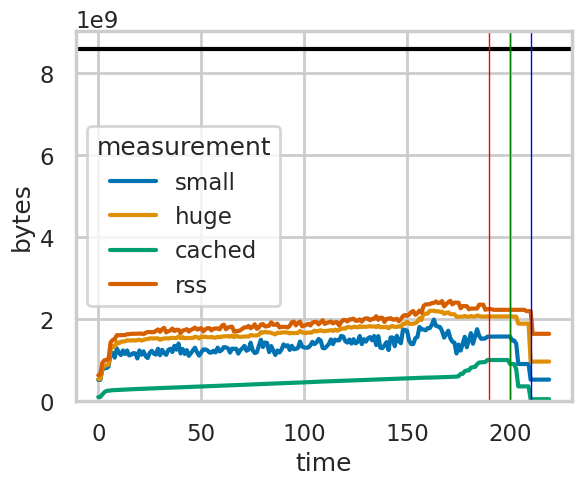

In [4]:
# Buddy, Free-Page-Reporting, 8G, 8C
root = Path("compiling/240410-160928-llfree-auto")
max_mem = 8*1024**3
data = pd.read_csv(root / "out_0.csv")
data["small"] = max_mem - data["small"] * 2**12
data["huge"] = max_mem - data["huge"] * 2**(12+9)
data["alloc"] = "LLFree"
data["time"] = data.index
data = data.melt(
    id_vars=["alloc", "time"],
    var_name="measurement",
    value_name="bytes",
    value_vars=["small", "huge", "cached", "rss"])
times = json.load((root / "times_0.json").open())

p = sns.lineplot(data=data, x="time", y="bytes", hue="measurement")
p.set_ylim(0, max_mem * 1.05)
p.axhline(y=max_mem, color="black")
p.axvline(x=times["build"], color="red", linewidth=1)
p.axvline(x=times["delay"], color="green", linewidth=1)
p.axvline(x=times["clean"], color="blue", linewidth=1)

invalid literal for int() with base 10: 's'
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]


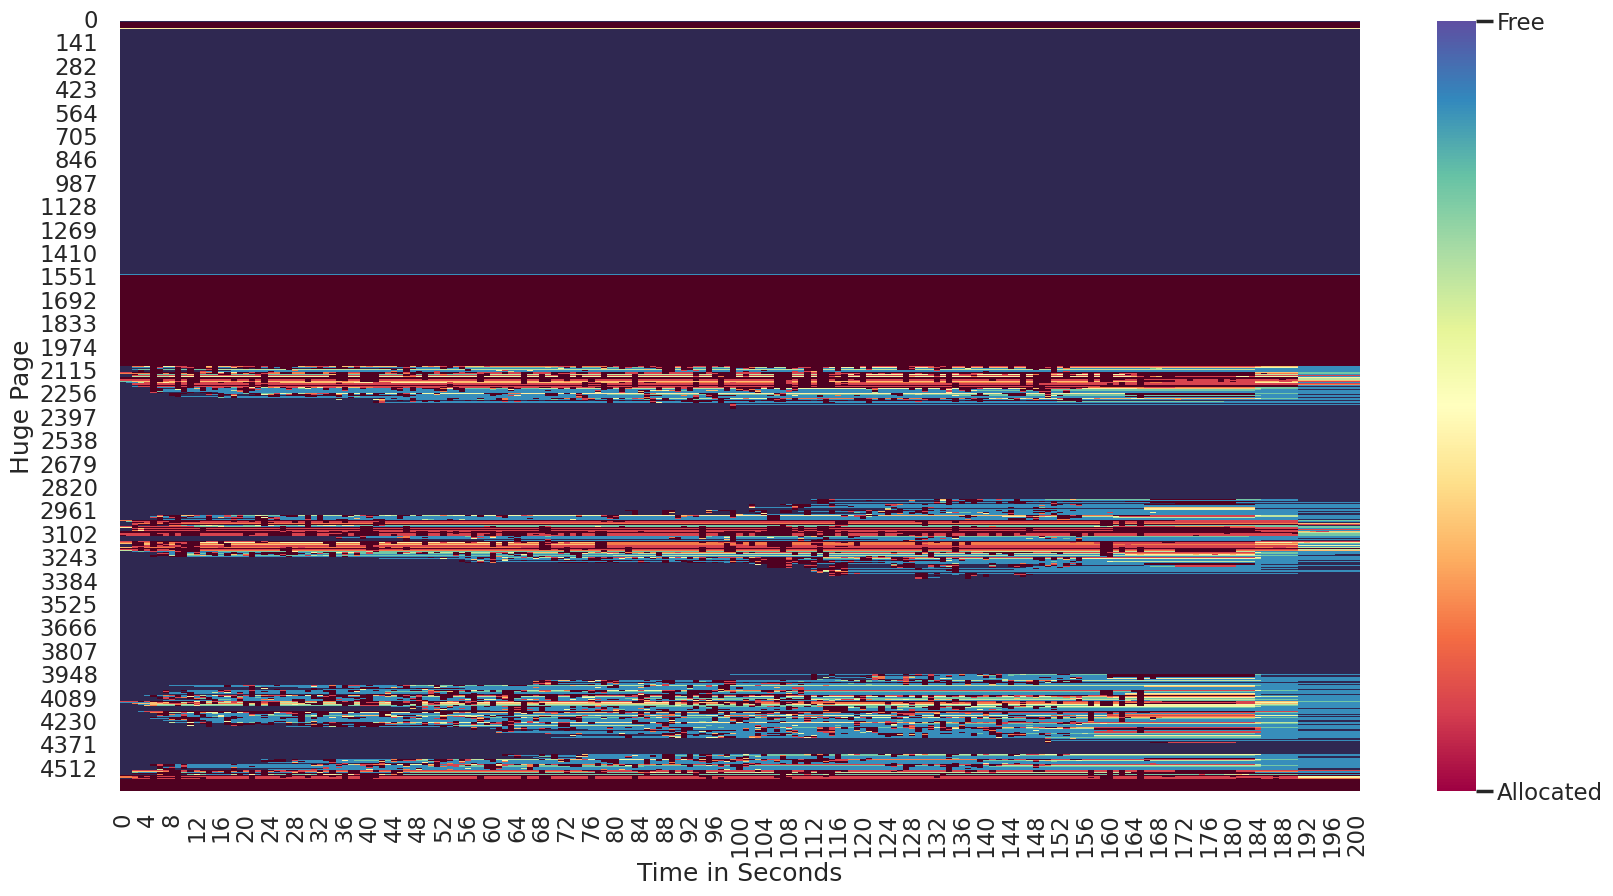

In [4]:
root = Path("compiling/240325-130205-llfree-auto")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception as e:
        print(e)
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])